# Large Scale Bayesian Inference of Log-Gaussian Cox Processes with Expectation Propagation for Traffic Density Estimation Problem

Use Environment: lgcp

# Generate road scenario

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from gp import sample_from_GP

In [2]:
# Road geometry
segment_length = 0.2 # meters
n_segments = 2 # number of segments
xs = np.linspace(0, segment_length * n_segments, n_segments)

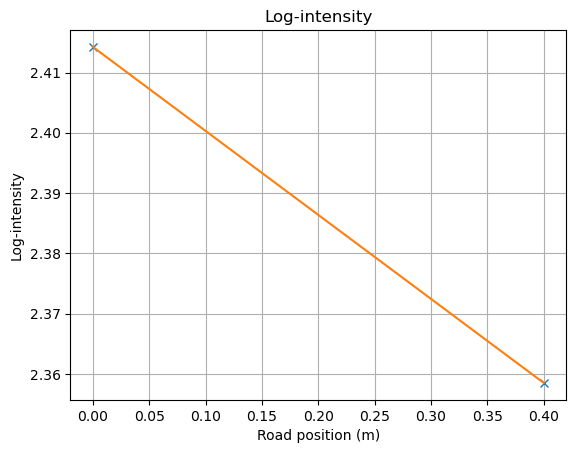

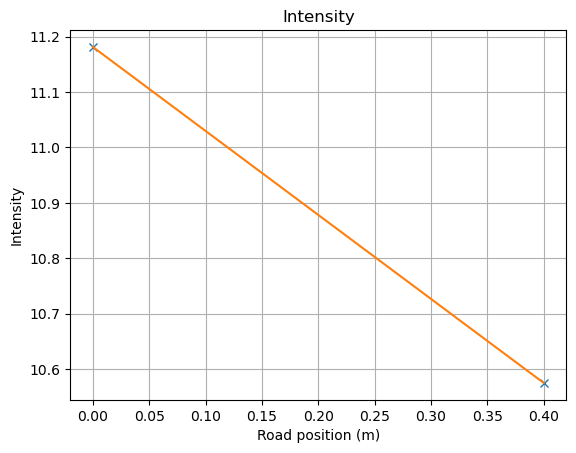

In [3]:
# Sample the log-intensity from GP
np.random.seed(6969)
log_intensity = sample_from_GP(xs, mean=2, var=5e-2, l=1)
plt.plot(xs, log_intensity, 'x')
plt.plot(xs, log_intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Log-intensity')
plt.title('Log-intensity')
plt.grid()
# intensity
intensity = np.exp(log_intensity)
plt.figure()
plt.plot(xs, intensity, 'x')
plt.plot(xs, intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Intensity')
plt.title('Intensity')
plt.grid()

In [4]:
# Sample vehicle positions from intensity using Poisson point process
n_vehicles = []
vehicle_positions = []
for segment in range(n_segments):
    # Sample number of vehicles in segment
    segment_n_vehicles = np.random.poisson(intensity[segment])
    # Add to list
    n_vehicles.append(segment_n_vehicles)
    # Sample vehicle positions in segment
    segment_vehicle_positions = np.random.uniform(0, segment_length, segment_n_vehicles)
    # Add segment offset
    segment_vehicle_positions += segment * segment_length
    # Add to list
    vehicle_positions.extend(segment_vehicle_positions)

# Convert to numpy array
vehicle_positions = np.array(vehicle_positions)
n_vehicles = np.array(n_vehicles)


# Generate measurements

Text(0.5, 1.0, 'Measurement Positions')

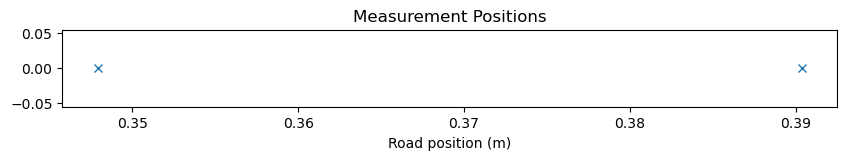

In [5]:
# Generate 100 measurements 
n_measurements = 2
max_road_position = n_segments * segment_length
measurement_positions = np.random.uniform(0, max_road_position, n_measurements)
plt.figure(figsize=(10, 1))
plt.plot(measurement_positions, np.zeros_like(measurement_positions), 'x')
plt.xlabel('Road position (m)')
plt.title('Measurement Positions')

In [6]:
measurement_range = 0.1
measurement_segment_counts = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement
measurement_segment_counts_extrapolated = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement, extrapolated with the segment length
for i, measurement_position in enumerate(measurement_positions):
    # List all the vehicles in the measurement range
    in_range_bools = np.logical_and(vehicle_positions > measurement_position - measurement_range, vehicle_positions < measurement_position + measurement_range) # boolean array of all vehicles: True if in range
    in_range = vehicle_positions[in_range_bools] # list of vehicle positions in range
    # Count the number of vehicles in each segment
    segment_counts = np.zeros((n_segments,))
    segment_counts_extrapolated = np.zeros((n_segments,))
    for segment in range(n_segments):
        segment_counts[segment] = np.sum(np.logical_and(in_range > segment * segment_length, in_range < (segment + 1) * segment_length))
        if segment_counts[segment] > 0:
            # Find the length of the intersection between the segment and the measurement range
            segment_start = segment * segment_length
            segment_end = (segment + 1) * segment_length
            intersection_start = max(segment_start, measurement_position - measurement_range)
            intersection_end = min(segment_end, measurement_position + measurement_range)
            intersection_length = intersection_end - intersection_start
            # Extrapolate the number of vehicles in the segment using the intersection length
            segment_counts_extrapolated[segment] = segment_counts[segment] * segment_length / intersection_length
    measurement_segment_counts[i, :] = segment_counts
    measurement_segment_counts_extrapolated[i, :] = segment_counts_extrapolated

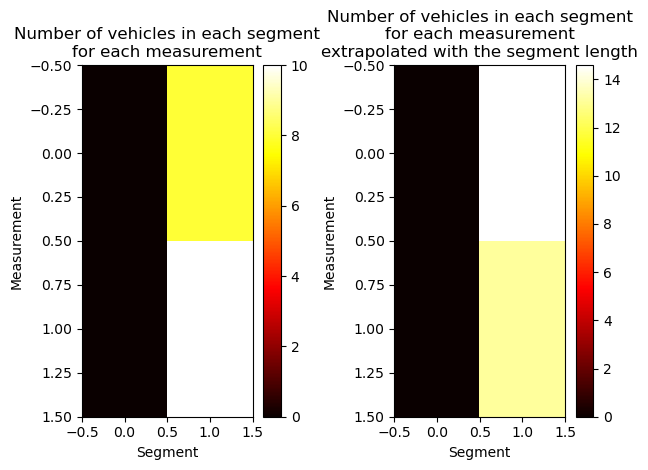

In [7]:
# Visualize the measurements
plt.subplot(1, 2, 1)
plt.imshow(measurement_segment_counts, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(measurement_segment_counts_extrapolated, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement\nextrapolated with the segment length')
plt.colorbar()
plt.tight_layout()

# Inference

Posterior update for normal distributions

In [8]:
# Gaussian distribution posterior update
def gaussian_posterior_update_scalar(mean1, var1, mean2, var2):
    prec1 = 1/var1
    prec2 = 1/var2
    var = 1/(prec1 + prec2)
    # print('var1 = {}'.format(var1[:3,:3]))
    mean = var * (prec1 * mean1 + prec2 * mean2)
    # print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update(mean1, var1, mean2, var2):
    prec1 = np.linalg.inv(var1)
    prec2 = np.linalg.inv(var2)
    var = np.linalg.inv(prec1 + prec2)
    # print('var1 = {}'.format(var1[:3,:3]))
    mean = var @ (prec1 @ mean1 + prec2 @ mean2)
    # print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update_list(means, vars):
    mean = means[0,:]
    var = vars[0,:,:]
    for i in range(1, means.shape[0]):
        # print('Iter B {}: mean = {}'.format(i, mean[:5]))
        mean, var = gaussian_posterior_update(mean, var, means[i,:], vars[i,:,:])
        # print('Iter A {}: mean = {}'.format(i, mean[:5]))
    return mean, var

Laplace approximation for Normal-Poisson observation model

In [9]:
def laplace_mean_through_fpi(rho_j, C_tilde_star, nj, mu_tilde_star, A, max_iter=100, tol=1e-9, verbose=False):
    y = np.zeros_like(mu_tilde_star) # initialize y
    one_j = np.zeros_like(mu_tilde_star)
    one_j[rho_j] = 1
    for iter in range(max_iter):
        if verbose:
            print('y: {}'.format(y[:5]))
        y_new = mu_tilde_star + C_tilde_star @ ((nj - A*np.exp(y)) * one_j)
        if verbose:
            print('Delta y: {}'.format(C_tilde_star @ ((nj - A*np.exp(y)) * one_j)))
        if np.linalg.norm(y_new - y) < tol:
            if verbose:
                print('Converged')
                print('Error: {}'.format(np.linalg.norm(y_new-y)))
            break
        y = y_new
        if verbose:
            print('=>{}, y: {}'.format(iter, y[:5]))
            print('-----------------')
    return y_new

def laplace_var(rho_j, C_tilde_star, A, y, verbose=False):
    res = -np.linalg.inv(C_tilde_star)
    res[rho_j, rho_j] += A*np.exp(y[rho_j])
    return -np.linalg.inv(res)

Expectation Propagation

In [10]:
from gp import gram_matrix
# Expectation Propagation (EP)

# Initialize the EP parameters
# Intractable component approximators / log-likelihood
mu_tildes = np.zeros((n_measurements, n_segments))
var_tildes = np.zeros((n_measurements, n_segments, n_segments))
for i in range(n_measurements):
    var_tildes[i, :, :] = np.eye(n_segments) * 1e-3

# Tractable components approximator / prior
mu_zero = np.ones((n_segments,)) * 2
# var_zero = gram_matrix(xs, var=5e-1, l=2)
var_zero = np.eye(n_segments) * 1e-1

In [11]:
from tqdm import tqdm

max_ep_iterations = 1
verbose = True
np.random.seed(6969)
for ep_iteration in (pbar := tqdm(range(max_ep_iterations))):
    # Choose a random measurement index j component to refine
    j = np.random.randint(0, n_measurements)
    # ==================    q_minus_j    ==================
    q_minus_j_means_param = np.concatenate((mu_zero.reshape((1,-1)), np.delete(mu_tildes, j, axis=0)))
    q_minus_j_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), np.delete(var_tildes, j, axis=0)))
    mu_q_minus_j, var_q_minus_j = gaussian_posterior_update_list(means = q_minus_j_means_param, vars = q_minus_j_vars_param)
    # ==================    Tilted Distribution    ==================
    measurement_segment_counts_extrapolated_j = measurement_segment_counts_extrapolated[j, :]
    # Segment index is the first non-zero element
    segment_index_j = np.argmax(measurement_segment_counts_extrapolated_j > 0)
    # Number of vehicles in the segment
    nj = measurement_segment_counts_extrapolated_j[segment_index_j]
    # Rename the variables so that they are consistent with the paper
    # q_minus_j's covariance matrix and mean vector
    C_tilde_star = var_q_minus_j
    mu_tilde_star = mu_q_minus_j
    # A is the segment length
    A = segment_length
    # Index of the segment to be updated with Laplace approximation
    rho_j = segment_index_j
    # Print the parameters
    if verbose:
        print('j / Index of Measurement: {}'.format(j))
        print('rho_j / Index of Segment: {}'.format(rho_j))
        print('nj / Segment Count: {}'.format(nj))
        print('A / Segment Length: {}'.format(A))
        print('mu_tilde_star / q_minus_j mean: {}'.format(mu_tilde_star[:5]))
        print('C_tilde_star / q_minus_j var:\n{}'.format(C_tilde_star[:5,:5]))
    # ==================    Laplace Approximation    ==================
    lmean = laplace_mean_through_fpi(rho_j, C_tilde_star, nj, mu_tilde_star, A, verbose=verbose)
    lvar = laplace_var(rho_j, C_tilde_star, A, lmean, verbose=verbose)
    # ==================    Update the EP parameters    ==================
    iter_mean_difference = lmean - mu_tilde_star # difference in the means
    iter_var_difference = 1/(np.linalg.inv(lvar) - np.linalg.inv(C_tilde_star))
    if True:
        mu_tildes[j, :] = lmean - mu_tilde_star # replace the jth intractable component with Laplace mean
        print('Mean imitator set to: {}'.format(mu_tildes[j, :]))
        var_tildes[j, rho_j, rho_j] = 1/(1/C_tilde_star[rho_j, rho_j] + A*np.exp(lmean[rho_j]))
    delta_diff_of_mean = np.linalg.norm(iter_mean_difference)
    tqdm.set_description(pbar, 'Delta diff of mean: {}'.format(delta_diff_of_mean))

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/8k/_h2zg_z51q9fpsbmsh42bd3h0000gn/T/ipykernel_4582/4095504524.py:40: RuntimeWarning: divide by zero encountered in divide
  iter_var_difference = 1/(np.linalg.inv(lvar) - np.linalg.inv(C_tilde_star))
Delta diff of mean: 0.01281570467614013: 100%|██████████| 1/1 [00:00<00:00, 518.71it/s]

j / Index of Measurement: 1
rho_j / Index of Segment: 1
nj / Segment Count: 13.15049281745391
A / Segment Length: 0.2
mu_tilde_star / q_minus_j mean: [0.01980198 0.01980198]
C_tilde_star / q_minus_j var:
[[0.0009901 0.       ]
 [0.        0.0009901]]
y: [0. 0.]
Delta y: [0.         0.01282227]
=>0, y: [0.01980198 0.03262425]
-----------------
y: [0.01980198 0.03262425]
Delta y: [0.        0.0128157]
=>1, y: [0.01980198 0.03261768]
-----------------
y: [0.01980198 0.03261768]
Delta y: [0.        0.0128157]
=>2, y: [0.01980198 0.03261768]
-----------------
y: [0.01980198 0.03261768]
Delta y: [0.        0.0128157]
Converged
Error: 2.748565264276692e-13
Mean imitator set to: [0.        0.0128157]


In [ ]:
# Compute the final posterior
q_means_param = np.concatenate((mu_zero.reshape((1,-1)), mu_tildes))
q_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), var_tildes))
mu_q, var_q = gaussian_posterior_update_list(means = q_means_param, vars = q_vars_param)
plt.plot(mu_q)
plt.xlabel('Segment Index')
plt.ylabel('Log-Intensity')

# Sanity Check

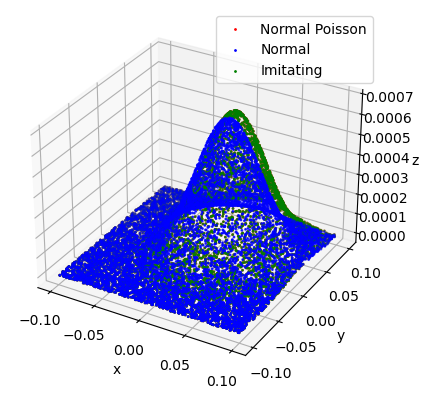

In [25]:
from scipy.stats import multivariate_normal

# ==================    Test    ==================
n_samples = 10_000
# uniformly sample from a 2d uniform distribution
particles = np.random.uniform(low=-.1, high=.1, size=(n_samples, 2))
# Normal-Poisson (the tilted distribution)
normal_poisson = multivariate_normal.pdf(particles, mean=mu_tilde_star, cov=C_tilde_star) * np.exp(nj * particles[:, 1] - A * np.exp(particles[:, 1]))
normal_poisson /= np.sum(normal_poisson)
# The j-excluded normal distribution
normal = multivariate_normal.pdf(particles, mean=mu_tilde_star, cov=C_tilde_star)
normal /= np.sum(normal)
# The imitating distribution by Laplace approximation
imitating = multivariate_normal.pdf(particles, mean=lmean, cov=lvar)
imitating /= np.sum(imitating)

# 3d histogram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(particles[:, 0], particles[:, 1], normal_poisson, s=1, c='r')
ax.scatter(particles[:, 0], particles[:, 1], normal, s=1, c='b')
ax.scatter(particles[:, 0], particles[:, 1], imitating, s=1, c='g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(['Normal Poisson', 'Normal', 'Imitating'])
plt.show()


In [ ]:
yrhoj_laplace_mean = np.log(nj/A)
print('Mean : ', yrhoj_laplace_mean)
yrhoj_laplace_var = 1/(A * np.exp(np.log(nj/A)))
print('Var: ', yrhoj_laplace_var)
# sample from the normal distribution
samples = np.random.normal(loc=yrhoj_laplace_mean, scale=np.sqrt(yrhoj_laplace_var), size=n_samples)
plt.hist(samples, bins=100)
plt.title('Laplace')

In [ ]:
mu_q_minus_j_rho_j = mu_q_minus_j[rho_j]
var_q_minus_j_rho_j = var_q_minus_j[rho_j, rho_j]
print('mu_q_minus_j_rho_j: ', mu_q_minus_j_rho_j)
print('var_q_minus_j_rho_j: ', var_q_minus_j_rho_j)

Note that we cannot Laplace approximate the Poisson distribution by a Normal distribution, then "fuses" this distribution to get a posterior distribution. The correct way to do is to Laplace approximate directly the joint Poisson-Normal distribution with the laplace_mean_through_fpi function. The following code explains why.

In [ ]:
post_mu_q, post_mu_var = gaussian_posterior_update_scalar(mean1 = mu_q_minus_j_rho_j, var1 = var_q_minus_j_rho_j, mean2 = yrhoj_laplace_mean, var2 = yrhoj_laplace_var)

In [ ]:
print('Posterior mean: ', post_mu_q)
print('Posterior var: ', post_mu_var)

In [ ]:
lmean = laplace_mean_through_fpi(rho_j, C_tilde_star, nj, mu_tilde_star, A, verbose=True)
print(lmean[rho_j])

We verify that the fixed point iteration gives the correct solution to the Laplace approximation of the Poisson distribution.

In [ ]:
# Test the first derivative equals zero
def f(y):
    one_j = np.zeros((n_segments,))
    one_j[rho_j] = 1
    return -np.linalg.inv(C_tilde_star) @ (y - mu_tilde_star) + (nj - A*np.exp(y)) * one_j

f(lmean)

Check the titled distribution is well approximated!

# Scratch

In [14]:
1/1010

0.0009900990099009901